In [30]:
import json
import pathlib
import sys
from io import StringIO
from IPython.display import display, SVG

import svgwrite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lxml import etree
from lxml.builder import E

sys.path.append(str(pathlib.Path().resolve().parents[1]))
from src.util.db_utils import SynFermDatabaseConnection
from src.util.color_palette import BodeColorPalette
from src.definitions import DATA_DIR

In [31]:
con = SynFermDatabaseConnection()  # we use this to conveniently get the paper names, not for data

In [32]:
# import data from curated data set
df = pd.read_csv(DATA_DIR / "curated_data" / f"synferm_dataset_2023-12-20_39486records.csv")
len(df)

39486

In [33]:
df.head()

,I_long,M_long,T_long,product_A_smiles,I_smiles,M_smiles,T_smiles,reaction_smiles,reaction_smiles_atom_mapped,experiment_id,...,binary_H,scaled_A,scaled_B,scaled_C,scaled_D,scaled_E,scaled_F,scaled_G,scaled_H,major_A-C
0,2-Pyr003,Fused002,TerABT004,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cccc(Cl)n3)[C...,O=C(c1cccc(Cl)n1)[B-](F)(F)F.[K+],COc1ccc(CCOC(=O)N2C[C@@H]3NO[C@]4(OC5(CCCCC5)O...,Nc1ccc(F)cc1S,O=C(c1cccc(Cl)n1)[B-](F)(F)F.COc1ccc(CCOC(=O)N...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,56113,...,0,0.035906,0.003423,0.0,0.021553,0.002986,0.939121,0.903610,0.0000,A
1,2-Pyr003,Fused002,TerABT007,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cccc(Cl)n3)[C...,O=C(c1cccc(Cl)n1)[B-](F)(F)F.[K+],COc1ccc(CCOC(=O)N2C[C@@H]3NO[C@]4(OC5(CCCCC5)O...,Nc1cc(Br)ccc1S,O=C(c1cccc(Cl)n1)[B-](F)(F)F.COc1ccc(CCOC(=O)N...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,56114,...,0,0.000000,0.000000,0.0,0.006328,0.367872,0.926031,1.093633,0.0000,no_product
2,2-Pyr003,Fused002,TerABT013,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cccc(Cl)n3)[C...,O=C(c1cccc(Cl)n1)[B-](F)(F)F.[K+],COc1ccc(CCOC(=O)N2C[C@@H]3NO[C@]4(OC5(CCCCC5)O...,Nc1cc(C(F)(F)F)ccc1S,O=C(c1cccc(Cl)n1)[B-](F)(F)F.COc1ccc(CCOC(=O)N...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,56106,...,1,0.000000,0.000000,0.0,0.014604,2.187072,1.010519,0.531508,0.0566,no_product
3,2-Pyr003,Fused002,TerABT014,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cccc(Cl)n3)[C...,O=C(c1cccc(Cl)n1)[B-](F)(F)F.[K+],COc1ccc(CCOC(=O)N2C[C@@H]3NO[C@]4(OC5(CCCCC5)O...,Nc1ccc(Cl)cc1S,O=C(c1cccc(Cl)n1)[B-](F)(F)F.COc1ccc(CCOC(=O)N...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,56112,...,0,0.028822,0.005032,0.0,0.016007,0.508862,0.989601,0.880251,0.0000,A
4,2-Pyr003,Fused002,TerTH001,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cccc(Cl)n3)[C...,O=C(c1cccc(Cl)n1)[B-](F)(F)F.[K+],COc1ccc(CCOC(=O)N2C[C@@H]3NO[C@]4(OC5(CCCCC5)O...,[Cl-].[NH3+]NC(=S)c1ccccc1,O=C(c1cccc(Cl)n1)[B-](F)(F)F.COc1ccc(CCOC(=O)N...,F[B-](F)(F)[C:1](=[O:2])[c:11]1[cH:12][cH:14][...,56109,...,0,0.348936,0.642356,0.0,0.032561,0.619445,0.108977,0.433894,0.0000,B


In [34]:
df["major_A-C"].value_counts().sort_index()

A             21640
B              8695
C              3454
no_product     5697
Name: major_A-C, dtype: int64

In [35]:
def get_class(series):
    sorted_series = series.sort_values()  # sort so that ties will be broken in a consistent way
    most_frequent_value = sorted_series.value_counts().index[0]
    if most_frequent_value == "A":
        return "major-A"
    if most_frequent_value == "B":
        return "major-B"
    if most_frequent_value == "C":
        return "major-C"
    if most_frequent_value == "no_product":
        return "major-none"

In [36]:
x_axis = "Monomer"
y_axis = "Initiator"

In [37]:
x_index = np.sort(df[f"{x_axis[0]}_long"].unique())
y_index = np.sort(df[f"{y_axis[0]}_long"].unique())

In [38]:
# some settings for the plot
rect_x = 20
rect_y = 20
text_len = 30

x_total = len(x_index) * rect_x + text_len
y_total = len(y_index) * rect_y + text_len

# set root
svg = E.svg(viewBox=f"0 0 {x_total} {y_total}")

# set internal CSS styles
style = E.style("""
.major-A {
  fill: #5790fc;
  stroke: #729ef5;
}
.major-B {
  fill: #f89c20;
  stroke: #f6b45e;
}
.major-C {
  fill: #adad7d;
  stroke: #aaaaaa;
}
.major-none {
  fill: #e42536;
  stroke: #de4e5b;
}
.axes {
  stroke: black; 
}
.axes-labels {
  fill: black;
  font-family: Helvetica, sans-serif;
  font-size: 12px;
  font-weight: bold;
}
""")
svg.append(style)

# set axes
#axes = E.g()
#axes.set("class", "axes")
#axes.append(E.line(x1=str(text_len), x2=str(x_total), y1=str(y_total - text_len), y2=str(y_total - text_len)))  # x-axis
#axes.append(E.line(x1=str(text_len), x2=str(text_len), y1="0", y2=str(y_total - text_len)))  # y-axis
#svg.append(axes)

# set axes labels
axes_labels = E.g()
axes_labels.set("class", "axes-labels")
x_labels = E.text(transform=f"translate({text_len + ((rect_x - 12) / 2)} {2 * y_total}) rotate(-90)")
y_labels = E.text(x="0", y=str(rect_y), transform=f"translate(0 {(rect_y - 12) / 2})")  # translate to have the label in the middle of the box, not end

# x-axis labels
for i_x, x_label in enumerate(x_index):
    # n.b. the labels use the "paper names" from the 50k publication
    tspan = E.tspan(con.get_paper_name(long=x_label), y=str((i_x + 0.5) * rect_x), x=str(y_total))
    x_labels.append(tspan)

# y-axis labels
for i_y, y_label in enumerate(y_index):
    # n.b. the labels use the "paper names" from the 50k publication
    tspan = E.tspan(con.get_paper_name(long=y_label), x="0", y=str((i_y + 0.5) * rect_y))
    y_labels.append(tspan)

# Append the tspan elements
axes_labels.append(x_labels)
axes_labels.append(y_labels)
svg.append(axes_labels)

# set heatmap squares
squares = E.g()
squares.set("class", "heatmap-squares")

for i_x, x in enumerate(x_index):
    for i_y, y in enumerate(y_index):
        data = df.loc[(df[f"{x_axis[0]}_long"] == x) & (df[f"{y_axis[0]}_long"] == y)]
        if len(data) > 0:
            offset_x = rect_x * i_x + text_len
            offset_y = rect_y * i_y
            square = E.rect(x=str(offset_x), y=str(offset_y), width=str(rect_x), height=str(rect_y), id=f"{x}_{y}")
            square.set("class", get_class(data["major_A-C"]))
            squares.append(square)
svg.append(squares)

# render to string
s = etree.tostring(svg, pretty_print=True)

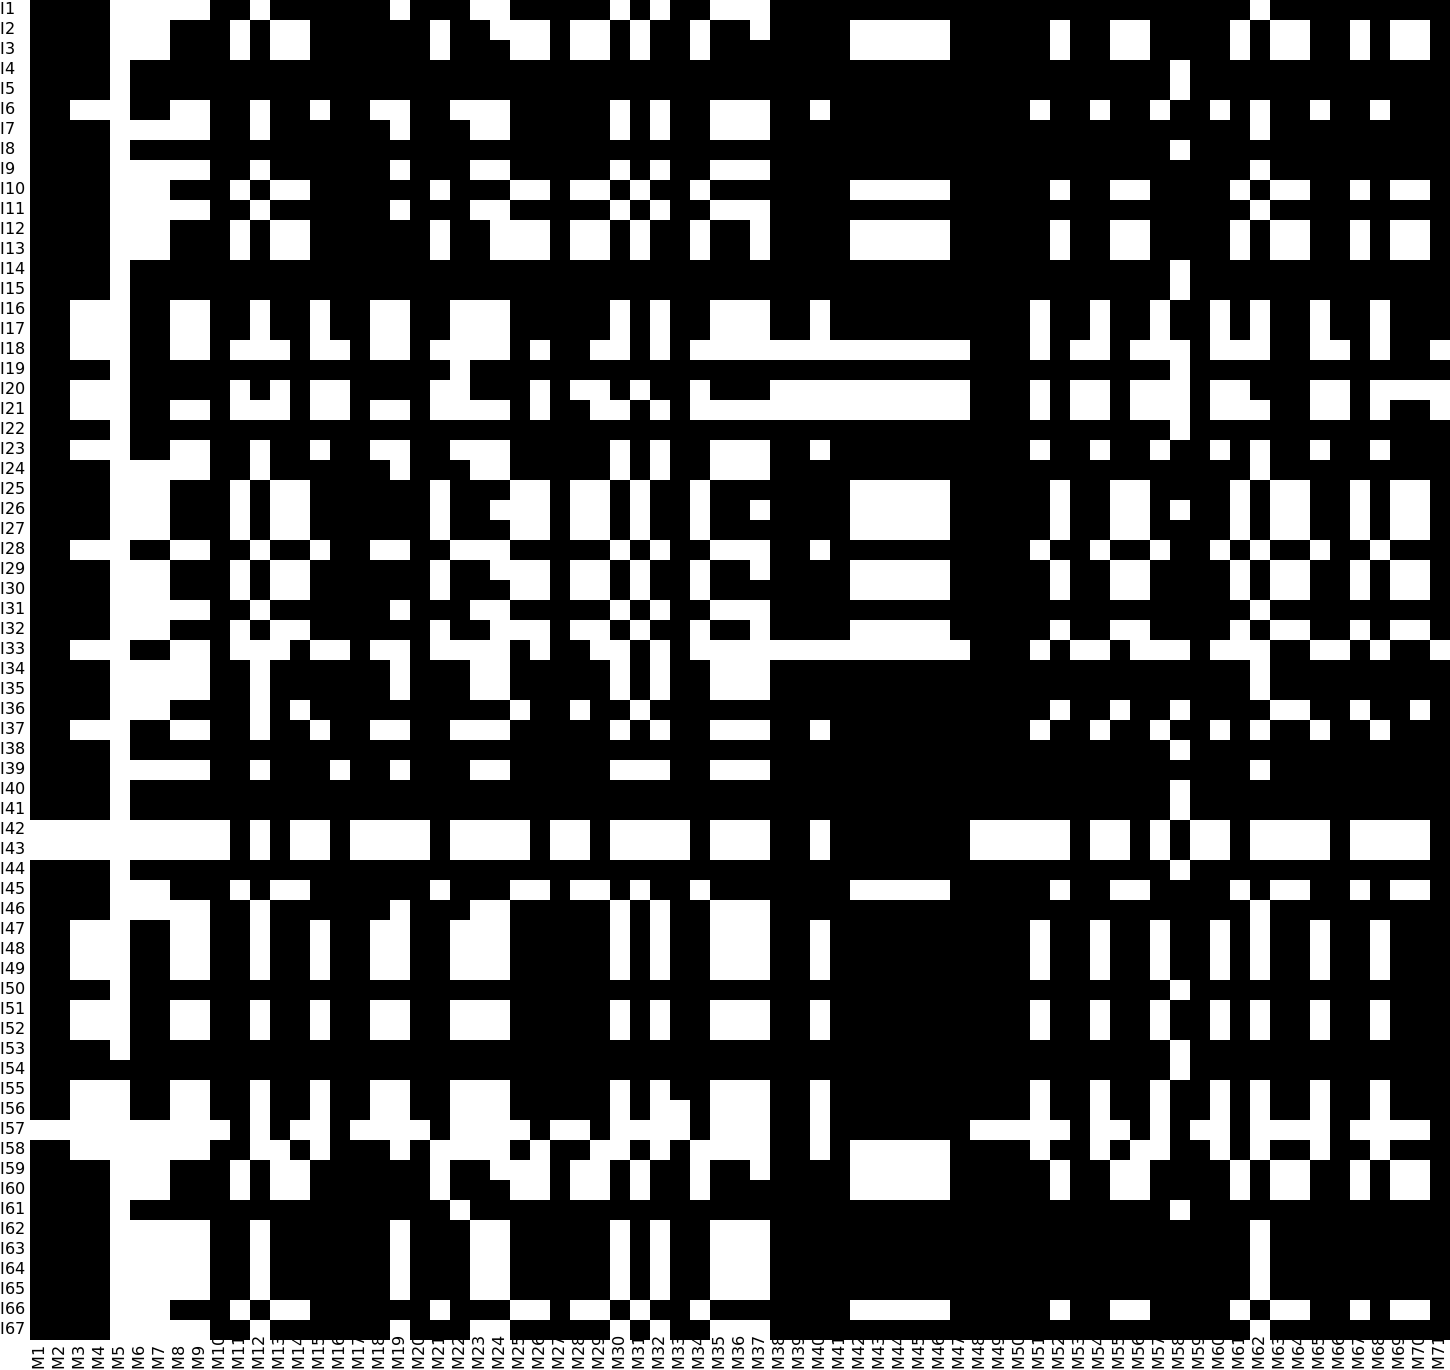

In [39]:
display(SVG(s))

In [40]:
with open("/Users/julian/Desktop/sf_heatmap_majorProduct_paper-names.svg", "wb") as f:
    f.write(etree.tostring(svg, pretty_print=True))

In [12]:
# we will need a JSON dict to relate identifiers to data points / SVG images
relations = {}
for i_x, x in enumerate(x_index):
    for i_y, y in enumerate(y_index):
        identifier = f"{x}_{y}"
        data = df.loc[(df[f"{x_axis[0]}_long"] == x) & (df[f"{y_axis[0]}_long"] == y)]
        if len(data) > 0:
            filenames = [f"product_images/{row['I_long']}_{row['M_long']}_{row['T_long']}.svg" for i, row in data.iterrows()]
            major = [row['major_A-C'] for i, row in data.iterrows()]
            terminators = [con.get_paper_name(long=row['T_long']) for i, row in data.iterrows()]
        else:
            filenames = []
            major = {"A": 0, "B": 0, "C": 0, "none": 0}
            terminators = []
        relations[identifier] = {"filenames": filenames, "major": major, "terminator_paper_names": terminators}
            

In [13]:
print(relations)

{'Fused002_2-Pyr003': {'filenames': ['product_images/2-Pyr003_Fused002_TerABT004.svg', 'product_images/2-Pyr003_Fused002_TerABT007.svg', 'product_images/2-Pyr003_Fused002_TerABT013.svg', 'product_images/2-Pyr003_Fused002_TerABT014.svg', 'product_images/2-Pyr003_Fused002_TerTH001.svg', 'product_images/2-Pyr003_Fused002_TerTH005.svg', 'product_images/2-Pyr003_Fused002_TerTH011.svg', 'product_images/2-Pyr003_Fused002_TerTH014.svg', 'product_images/2-Pyr003_Fused002_TerTH019.svg', 'product_images/2-Pyr003_Fused002_TerTH025.svg'], 'major': ['A', 'no_product', 'no_product', 'A', 'B', 'B', 'A', 'B', 'A', 'B'], 'terminator_paper_names': ['T2', 'T5', 'T11', 'T12', 'T19', 'T23', 'T26', 'T29', 'T33', 'T38']}, 'Fused002_2-Pyr006': {'filenames': ['product_images/2-Pyr006_Fused002_TerABT006.svg', 'product_images/2-Pyr006_Fused002_TerABT008.svg', 'product_images/2-Pyr006_Fused002_TerABT012.svg', 'product_images/2-Pyr006_Fused002_TerABT016.svg', 'product_images/2-Pyr006_Fused002_TerABT017.svg', 'produ

In [14]:
with open("svg-relations.json", "w") as f:
    json.dump(relations, f)

In [41]:
# now we produce the same heatmap, but for binary_A instead of major_A-C
def get_class(series):
    most_frequent_value = series.value_counts().index[0]
    if most_frequent_value == 1:
        return "success"
    if most_frequent_value == 0:
        return "fail"

In [64]:
x_axis = "Monomer"
y_axis = "Initiator"

x_index = np.sort(df[f"{x_axis[0]}_long"].unique())
y_index = np.sort(df[f"{y_axis[0]}_long"].unique())

# some settings for the plot
rect_x = 20
rect_y = 20
text_len = 35

x_total = len(x_index) * rect_x + text_len
y_total = len(y_index) * rect_y + text_len

# set root
svg = E.svg(viewBox=f"0 0 {x_total} {y_total}")

# set internal CSS styles
style = E.style("""
.success {
  fill: #5790fc;
  stroke: #729ef5;
}
.fail {
  fill: #e42536;
  stroke: #de4e5b;
}

.axes-labels {
  fill: black;
  font-family: Helvetica, sans-serif;
  font-size: 16px;
  font-weight: normal;
}
""")
svg.append(style)



# set axes labels
axes_labels = E.g()
axes_labels.set("class", "axes-labels")
x_labels = E.text(transform=f"translate({text_len + ((rect_x - 12) / 2)} {2 * y_total}) rotate(-90)")
y_labels = E.text(x="0", y=str(rect_y), transform=f"translate(0 {(rect_y - 12) / 2})")  # translate to have the label in the middle of the box, not end

# x-axis labels
for i_x, x_label in enumerate(x_index):
    # n.b. the labels use the "paper names" from the 50k publication
    tspan = E.tspan(con.get_paper_name(long=x_label), y=str((i_x + 0.5) * rect_x), x=str(y_total))
    x_labels.append(tspan)

# y-axis labels
for i_y, y_label in enumerate(y_index):
    # n.b. the labels use the "paper names" from the 50k publication
    tspan = E.tspan(con.get_paper_name(long=y_label), x="0", y=str((i_y + 0.5) * rect_y))
    y_labels.append(tspan)

# Append the tspan elements
axes_labels.append(x_labels)
axes_labels.append(y_labels)
svg.append(axes_labels)

# set heatmap squares
squares = E.g()

for i_x, x in enumerate(x_index):
    for i_y, y in enumerate(y_index):
        data = df.loc[(df[f"{x_axis[0]}_long"] == x) & (df[f"{y_axis[0]}_long"] == y)]
        if len(data) > 0:
            offset_x = rect_x * i_x + text_len
            offset_y = rect_y * i_y
            square = E.rect(x=str(offset_x), y=str(offset_y), width=str(rect_x), height=str(rect_y), id=f"{x}_{y}")
            square.set("class", get_class(data["binary_A"]))
            squares.append(square)
svg.append(squares)

# render to string
s = etree.tostring(svg, pretty_print=True)

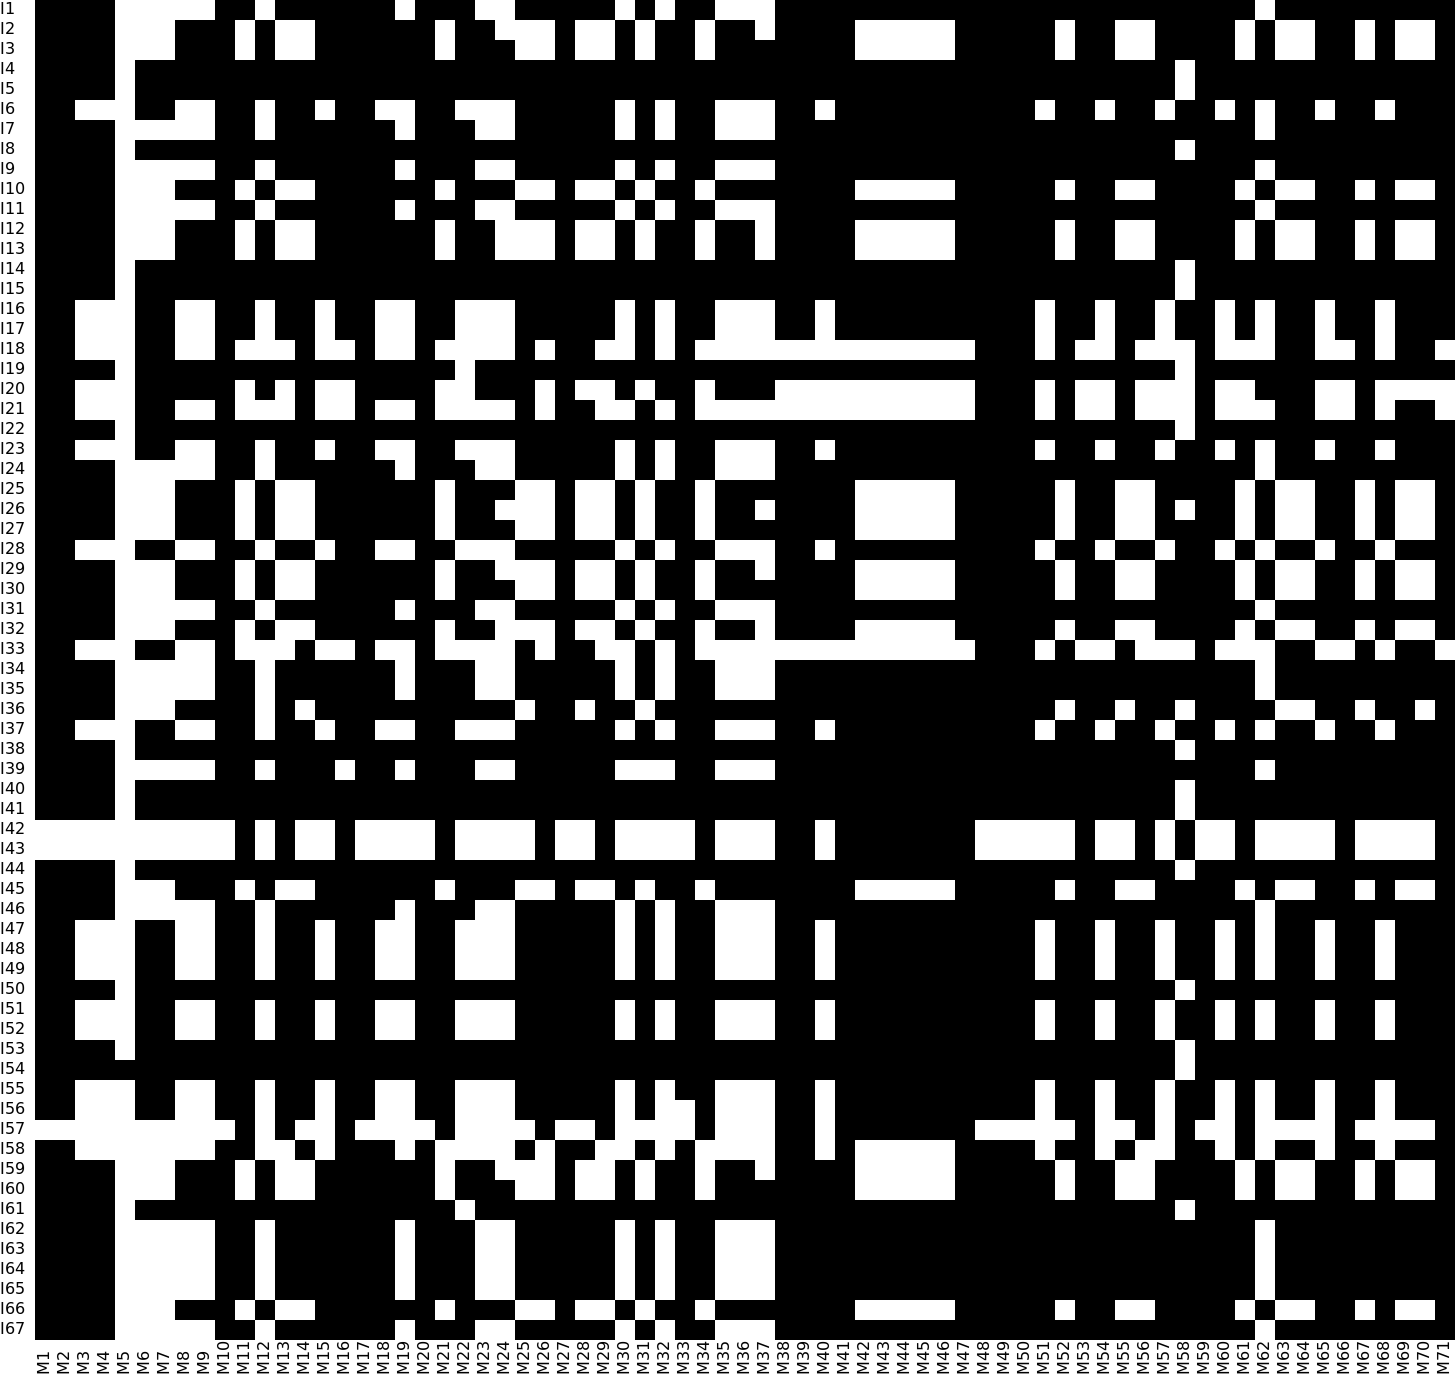

In [65]:
display(SVG(s))

In [66]:
with open("/Users/julian/Desktop/sf_heatmap_2023-12-20_binary-A_paper-names.svg", "wb") as f:
    f.write(etree.tostring(svg, pretty_print=True))

In [67]:
# same for B

x_axis = "Monomer"
y_axis = "Initiator"

x_index = np.sort(df[f"{x_axis[0]}_long"].unique())
y_index = np.sort(df[f"{y_axis[0]}_long"].unique())

# some settings for the plot
rect_x = 20
rect_y = 20
text_len = 35

x_total = len(x_index) * rect_x + text_len
y_total = len(y_index) * rect_y + text_len

# set root
svg = E.svg(viewBox=f"0 0 {x_total} {y_total}")

# set internal CSS styles
style = E.style("""
.success {
  fill: #f89c20;
  stroke: #f6b45e;
}
.fail {
  fill: #e42536;
  stroke: #de4e5b;
}

.axes-labels {
  fill: black;
  font-family: Helvetica, sans-serif;
  font-size: 16px;
  font-weight: normal;
}
""")
svg.append(style)



# set axes labels
axes_labels = E.g()
axes_labels.set("class", "axes-labels")
x_labels = E.text(transform=f"translate({text_len + ((rect_x - 12) / 2)} {2 * y_total}) rotate(-90)")
y_labels = E.text(x="0", y=str(rect_y), transform=f"translate(0 {(rect_y - 12) / 2})")  # translate to have the label in the middle of the box, not end

# x-axis labels
for i_x, x_label in enumerate(x_index):
    # n.b. the labels use the "paper names" from the 50k publication
    tspan = E.tspan(con.get_paper_name(long=x_label), y=str((i_x + 0.5) * rect_x), x=str(y_total))
    x_labels.append(tspan)

# y-axis labels
for i_y, y_label in enumerate(y_index):
    # n.b. the labels use the "paper names" from the 50k publication
    tspan = E.tspan(con.get_paper_name(long=y_label), x="0", y=str((i_y + 0.5) * rect_y))
    y_labels.append(tspan)

# Append the tspan elements
axes_labels.append(x_labels)
axes_labels.append(y_labels)
svg.append(axes_labels)

# set heatmap squares
squares = E.g()

for i_x, x in enumerate(x_index):
    for i_y, y in enumerate(y_index):
        data = df.loc[(df[f"{x_axis[0]}_long"] == x) & (df[f"{y_axis[0]}_long"] == y)]
        if len(data) > 0:
            offset_x = rect_x * i_x + text_len
            offset_y = rect_y * i_y
            square = E.rect(x=str(offset_x), y=str(offset_y), width=str(rect_x), height=str(rect_y), id=f"{x}_{y}")
            square.set("class", get_class(data["binary_B"]))
            squares.append(square)
svg.append(squares)

# render to string
s = etree.tostring(svg, pretty_print=True)


with open("/Users/julian/Desktop/sf_heatmap_2023-12-20_binary-B_paper-names.svg", "wb") as f:
    f.write(etree.tostring(svg, pretty_print=True))

In [68]:
# same for C

x_axis = "Monomer"
y_axis = "Initiator"

x_index = np.sort(df[f"{x_axis[0]}_long"].unique())
y_index = np.sort(df[f"{y_axis[0]}_long"].unique())

# some settings for the plot
rect_x = 20
rect_y = 20
text_len = 35

x_total = len(x_index) * rect_x + text_len
y_total = len(y_index) * rect_y + text_len

# set root
svg = E.svg(viewBox=f"0 0 {x_total} {y_total}")

# set internal CSS styles
style = E.style("""
.success {
  fill: #adad7d;
  stroke: #aaaaaa;
}
.fail {
  fill: #e42536;
  stroke: #de4e5b;
}

.axes-labels {
  fill: black;
  font-family: Helvetica, sans-serif;
  font-size: 16px;
  font-weight: normal;
}
""")
svg.append(style)



# set axes labels
axes_labels = E.g()
axes_labels.set("class", "axes-labels")
x_labels = E.text(transform=f"translate({text_len + ((rect_x - 12) / 2)} {2 * y_total}) rotate(-90)")
y_labels = E.text(x="0", y=str(rect_y), transform=f"translate(0 {(rect_y - 12) / 2})")  # translate to have the label in the middle of the box, not end

# x-axis labels
for i_x, x_label in enumerate(x_index):
    # n.b. the labels use the "paper names" from the 50k publication
    tspan = E.tspan(con.get_paper_name(long=x_label), y=str((i_x + 0.5) * rect_x), x=str(y_total))
    x_labels.append(tspan)

# y-axis labels
for i_y, y_label in enumerate(y_index):
    # n.b. the labels use the "paper names" from the 50k publication
    tspan = E.tspan(con.get_paper_name(long=y_label), x="0", y=str((i_y + 0.5) * rect_y))
    y_labels.append(tspan)

# Append the tspan elements
axes_labels.append(x_labels)
axes_labels.append(y_labels)
svg.append(axes_labels)

# set heatmap squares
squares = E.g()

for i_x, x in enumerate(x_index):
    for i_y, y in enumerate(y_index):
        data = df.loc[(df[f"{x_axis[0]}_long"] == x) & (df[f"{y_axis[0]}_long"] == y)]
        if len(data) > 0:
            offset_x = rect_x * i_x + text_len
            offset_y = rect_y * i_y
            square = E.rect(x=str(offset_x), y=str(offset_y), width=str(rect_x), height=str(rect_y), id=f"{x}_{y}")
            square.set("class", get_class(data["binary_C"]))
            squares.append(square)
svg.append(squares)

# render to string
s = etree.tostring(svg, pretty_print=True)


with open("/Users/julian/Desktop/sf_heatmap_2023-12-20_binary-C_paper-names.svg", "wb") as f:
    f.write(etree.tostring(svg, pretty_print=True))

In [56]:
# while we are at it, get the statistics for success rates by product
df[[i for i in df.columns if i.startswith("binary_")]].mean()

binary_A    0.820848
binary_B    0.577521
binary_C    0.285392
binary_D    0.809148
binary_E    0.857165
binary_F    0.933141
binary_G    0.860786
binary_H    0.486375
dtype: float64

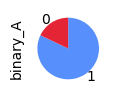

In [57]:
# while we are at it, get the statistics for success rates by product
df["binary_A"].value_counts().plot.pie(figsize=(1,1), colors=["#5790fc", "#e42536"], startangle=90, counterclock=False)
plt.savefig("/Users/julian/Desktop/binary-A_freq.svg")

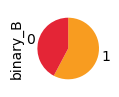

In [58]:
# while we are at it, get the statistics for success rates by product
df["binary_B"].value_counts().plot.pie(figsize=(1,1), colors=["#f89c20", "#e42536"], startangle=90, counterclock=False)
plt.savefig("/Users/julian/Desktop/binary-B_freq.svg")

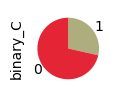

In [59]:
# while we are at it, get the statistics for success rates by product
df["binary_C"].value_counts().sort_index(ascending=False).plot.pie(figsize=(1,1), colors=["#adad7d", "#e42536"], startangle=90, counterclock=False)
plt.savefig("/Users/julian/Desktop/binary-C_freq.svg")

In [60]:
# also get the statistics on the main product
df["major_A-C"].value_counts() / len(df)

A             0.548042
B             0.220205
no_product    0.144279
C             0.087474
Name: major_A-C, dtype: float64

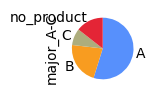

In [61]:
(df["major_A-C"].value_counts().sort_index() / len(df)).plot.pie(figsize=(1,1), colors=["#5790fc", "#f89c20", "#adad7d", "#e42536"], startangle=90, counterclock=False)
plt.savefig("/Users/julian/Desktop/major_A-C_freq.svg")